In [1]:
%matplotlib inline
import os
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

In [2]:
print('Set up config')
country_code = "US"
start_date='01/01/2010'
end_date='06/01/2020'
labels=['loss', 'unemployed', 'search', 'hire', 'offer', 'out_of_work']
features=['statuses_per_day','account_age']
if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/twitter/data'
else:
    path_to_data='../../data'
print('Country:', country_code)
print('End date:', start_date)
print('End date:', end_date)
print('Labels:',', '.join(labels))
print('Features:',', '.join(features))
print(path_to_data)

Set up config
Country: US
End date: 01/01/2010
End date: 06/01/2020
Labels: loss, unemployed, search, hire, offer, out_of_work
Features: statuses_per_day, account_age
../../data


In [3]:
print('Load')
start = timer()
users_counts=pq.ParquetDataset(glob(os.path.join(path_to_data,'classification',country_code,'users_counts','*.parquet'))).read().to_pandas()
unemployment_rates=pd.read_csv(os.path.join(path_to_data,'official','city',country_code,'time_series_unemployment_rate.csv'),index_col=0)
user_location_2_geo_id=pd.read_csv(os.path.join(path_to_data,'official','city',country_code,'user_location_2_geo_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load
Done in 7 sec


In [4]:
df=users_counts.merge(user_location_2_geo_id)
df.year=df.year.astype(int)
df.month=df.month.astype(int)
df=df.groupby(['year','month','geo_id','metro_area_name'],as_index=False)[labels+['user_id']].sum()
df[labels]=df[labels].divide(df['user_id'],0)
df=df.merge(unemployment_rates,on=['year','month','geo_id']).dropna()
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)
df.drop(['year','month','geo_id'],1,inplace=True)
df=df[(df['date']>=pd.to_datetime(start_date))&(df['date']<=pd.to_datetime(end_date))].copy()
top_metro_areas=df.groupby('metro_area_name')['user_id'].sum().sort_values(ascending=False).index[:5]
df=df.sort_values(by=['date','metro_area_name']).set_index(['date','metro_area_name'])

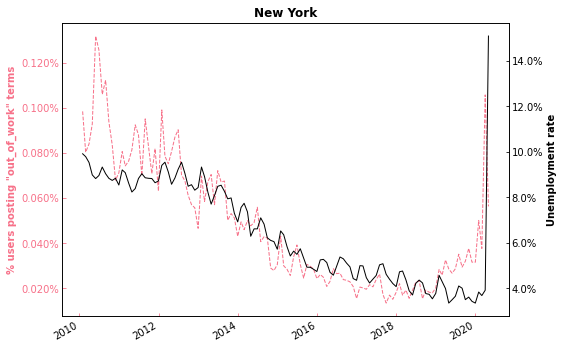

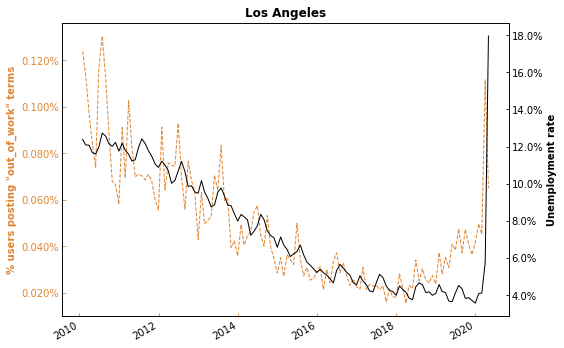

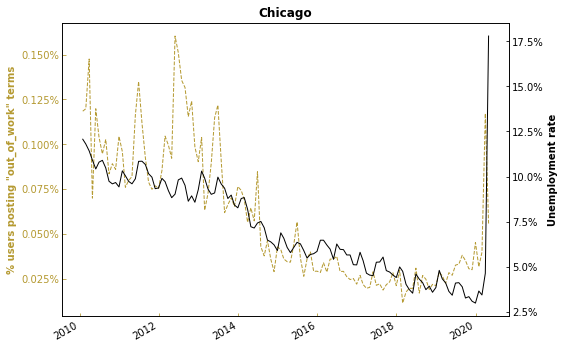

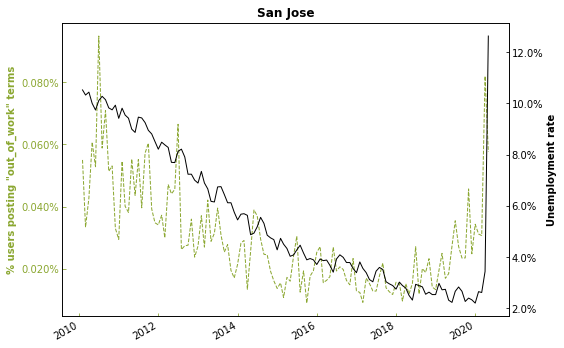

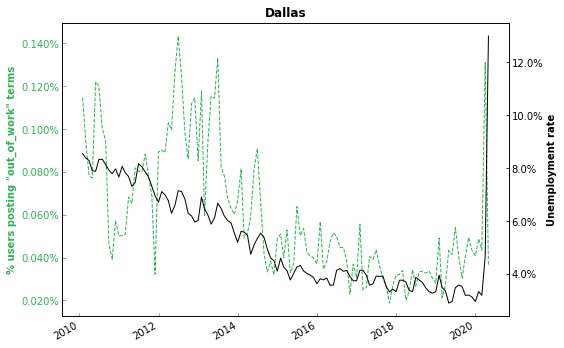

In [5]:
label='out_of_work'
colors = sns.color_palette("husl", 22)
for i,metro_area in enumerate(top_metro_areas):
    fig,ax1=plt.subplots(figsize=(8,6))
    ax2 = ax1.twinx()
    ax1.plot(df.xs(metro_area,level='metro_area_name').index,df.xs(metro_area,level='metro_area_name')[label],linewidth=1,color=colors[2*i],linestyle='dashed')
    ax2.plot(df.xs(metro_area,level='metro_area_name').index,df.xs(metro_area,level='metro_area_name')['unemployment_rate'],linewidth=1,color='k')
    ax1.tick_params(which='both',direction='in',pad=3,color=colors[2*i])
    ax2.tick_params(which='both',direction='in',pad=3,color='k')
    ax1.locator_params(axis='y',nbins=8)
    ax2.locator_params(axis='y',nbins=8)
    ax1.set_xlabel('')
    ax1.set_yticklabels(['{:,.3%}'.format(x) for x in ax1.get_yticks()],color=colors[2*i])
    ax2.set_yticklabels(['{:,.1%}'.format(x) for x in ax2.get_yticks()],color='k')
    ax1.set_ylabel('% users posting "'+label+'" terms',fontweight='bold',color=colors[2*i])
    ax2.set_ylabel('Unemployment rate',fontweight='bold',color='k')
    ax1.set_title(metro_area,fontweight='bold')
    fig.autofmt_xdate()